### Задание 3. CUPED (1 балла)

Cгенерируем выборку из $1000$ сэмплов экспоненциального распределения - это будут значения нашей метрики для $1000$ пользователей

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy import stats
from tqdm import tqdm

In [2]:
control_before = stats.expon(scale=1000).rvs(1000)

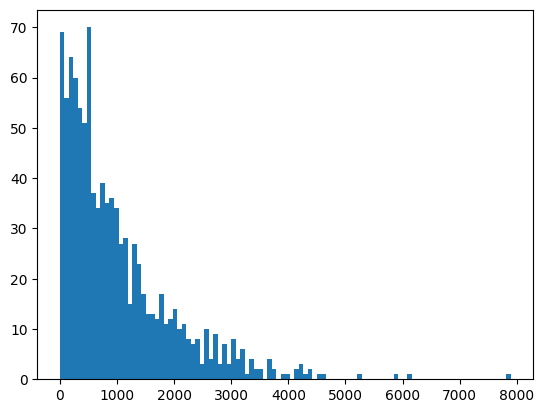

In [3]:
plt.hist(control_before, bins=100)
plt.show()

Предположим, что при наблюдении метрики в дальнейшем добавляется какой-то нормальный шум

In [4]:
control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

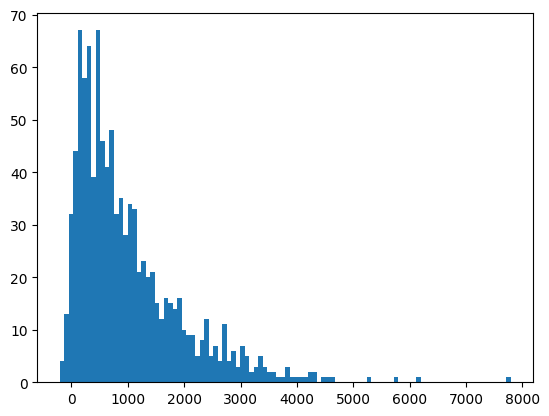

In [5]:
plt.hist(control, bins=100)
plt.show()

Теперь построим доверительный интервал для среднего значения нашей метрики и посмотрим, появилась ли стат значимая разница. Проведем такой эксперимент $10000$ раз

In [6]:
stats.norm(loc=control.mean(), scale=control.std() / np.sqrt(len(control))).ppf(
    [0.025, 0.975]
)

array([ 945.88328241, 1065.0373431 ])

In [7]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)
    left_bound, right_bound = stats.norm(
        loc=control.mean(), scale=control.std() / np.sqrt(len(control))
    ).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев;")

100%|██████████| 10000/10000 [00:08<00:00, 1171.06it/s]

Стат значимая разница есть в 5.48% случаев;


Как мы видим такой тест ошибается в около $5$% случаев, так как находит разницу в среднем. Ваша задача построить CUPED-метрику основываясь на данной метрике и провести аналогичный тест

In [8]:
bad_cnt = 0

N = 10000
for i in tqdm(range(N)):
    control_before = stats.expon(scale=1000).rvs(1000)
    control = control_before + stats.norm(loc=0, scale=100).rvs(1000)

    # Вычисляем CUPED
    theta = np.cov(control, control_before)[0,1] / np.var(control_before)
    cuped_metric = control - theta * (control_before - control_before.mean())
    
    mean = cuped_metric.mean()
    std = cuped_metric.std() / np.sqrt(len(cuped_metric))
    left_bound, right_bound = stats.norm(loc=mean, scale=std).ppf([0.025, 0.975])

    if left_bound > 1000 or right_bound < 1000:
        bad_cnt += 1

print(f"Стат значимая разница есть в  {round(bad_cnt / N, 4) * 100}% случаев;")

100%|██████████| 10000/10000 [00:08<00:00, 1154.91it/s]

Стат значимая разница есть в  84.96000000000001% случаев;


Результат должен получиться не очень хороший. Давайте теперь сделаем иначе: сгенерируем выборку из $10000$ значений, а затем выберем $2$ группы по $1000$ юзеров, которые будут нашими группами для теста. Опять добавим шум в обе группы аналогично тому, что показано в первом примере с теми же параметрами. Ваша задача вписать CUPED метрики используя знание обо всех $10000$ юзерах.

In [9]:
bad_cnt = 0
bad_cnt_original = 0

N = 10000
for i in tqdm(range(N)):
    control_before_full = stats.expon(scale=1000).rvs(1000 * 10)
    samples_in_ab = 2000
    indexes_to_take_a = np.random.choice(
        range(samples_in_ab), samples_in_ab // 2, False
    )
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]

    control_before_a = control_before_full[indexes_to_take_a]
    control_before_b = control_before_full[indexes_to_take_b]

    # Уменьшаем масштаб шума для увеличения корреляции
    control_after_a = control_before_a + stats.norm(loc=0, scale=20).rvs(
        samples_in_ab // 2
    )
    control_after_b = control_before_b + stats.norm(loc=0, scale=20).rvs(
        samples_in_ab // 2
    )

    # Вычисляем CUPED
    theta = np.cov(np.concatenate([control_after_a, control_after_b]), 
                  control_before_full[:samples_in_ab])[0,1] / np.var(control_before_full[:samples_in_ab])
    
    control_cup_a = control_after_a - theta * (control_before_a - control_before_full[:samples_in_ab].mean())
    control_cup_b = control_after_b - theta * (control_before_b - control_before_full[:samples_in_ab].mean())

    # Тест без CUPED
    if stats.ttest_ind(control_after_a, control_after_b).pvalue < 0.05:
        bad_cnt_original += 1
    
    # Тест с CUPED
    if stats.ttest_ind(control_cup_a, control_cup_b).pvalue < 0.05:
        bad_cnt += 1
    
    # Диагностика в первой итерации
    if i == 0:
        print(f"Theta value: {theta}")
        print(f"Correlation between pre and post: {np.corrcoef(control_before_full[:samples_in_ab], np.concatenate([control_after_a, control_after_b]))[0,1]}")
        print(f"Original variance A: {np.var(control_after_a)}")
        print(f"Original variance B: {np.var(control_after_b)}")
        print(f"CUPED variance A: {np.var(control_cup_a)}")
        print(f"CUPED variance B: {np.var(control_cup_b)}")
        print(f"Variance reduction ratio: {np.var(control_cup_a)/np.var(control_after_a):.4f}")

print(f"Стат значимая разница без CUPED есть в {round(bad_cnt_original / N, 4) * 100}% случаев;")
print(f"Стат значимая разница с CUPED есть в {round(bad_cnt / N, 4) * 100}% случаев;")

  0%|          | 35/10000 [00:00<00:56, 175.31it/s]

Theta value: -0.005768761905903228
Correlation between pre and post: -0.005763081968772461
Original variance A: 995111.6348932093
Original variance B: 968275.5789352196
CUPED variance A: 1006617.1687867248
CUPED variance B: 979472.1021095783
Variance reduction ratio: 1.0116


100%|██████████| 10000/10000 [00:53<00:00, 186.80it/s]

Стат значимая разница без CUPED есть в 4.92% случаев;
Стат значимая разница с CUPED есть в 4.92% случаев;


Результат получился уже совсем другой. Опишите свои мысли по поводу того, из-за чего возникает такая разница:



Далее проделаем такой же эксперимент при наличии реального смещения среднего значения и посмотрим на результаты с CUPED и без.

In [10]:
bad_cnt = 0
bad_cnt_cuped = 0

N = 10000
samples_in_ab = 2000  # Обязательно определить до использования

for i in tqdm(range(N)):
    # Шаг 1: Генерируем базовый уровень для каждого пользователя
    user_base_metrics = stats.norm(loc=100, scale=20).rvs(samples_in_ab)
    
    # Шаг 2: Разделяем на группы A и B
    indexes_to_take_a = np.random.choice(range(samples_in_ab), samples_in_ab // 2, False)
    indexes_to_take_b = [x for x in range(samples_in_ab) if x not in indexes_to_take_a]
    
    # Шаг 3: Pre-эксперимент значения (просто базовый уровень)
    pre_a = user_base_metrics[indexes_to_take_a]
    pre_b = user_base_metrics[indexes_to_take_b]
    
    # Шаг 4: Post-эксперимент значения (базовый уровень + эффект + шум)
    # Ключевой момент: маленький шум для высокой корреляции
    post_a = pre_a + stats.norm(loc=0, scale=5).rvs(len(pre_a))
    post_b = pre_b + stats.norm(loc=3, scale=5).rvs(len(pre_b))  # Эффект = 3
    
    # Шаг 5: Вычисляем CUPED
    # Используем все данные для оценки theta
    all_pre = np.concatenate([pre_a, pre_b])
    all_post = np.concatenate([post_a, post_b])
    
    # Формула CUPED
    theta = np.cov(all_post, all_pre)[0,1] / np.var(all_pre)
    
    # Применяем CUPED к обеим группам
    cuped_a = post_a - theta * (pre_a - all_pre.mean())
    cuped_b = post_b - theta * (pre_b - all_pre.mean())
    
    # Шаг 6: Проверяем мощность обычного t-теста
    if stats.ttest_ind(post_a, post_b).pvalue < 0.05:
        bad_cnt += 1
        
    # Шаг 7: Проверяем мощность CUPED t-теста
    if stats.ttest_ind(cuped_a, cuped_b).pvalue < 0.05:
        bad_cnt_cuped += 1
    
    # Диагностика для первой итерации
    if i == 0:
        print(f"Theta value: {theta}")
        print(f"Correlation between pre and post: {np.corrcoef(all_pre, all_post)[0,1]}")
        print(f"Original variance A: {np.var(post_a)}")
        print(f"Original variance B: {np.var(post_b)}")
        print(f"CUPED variance A: {np.var(cuped_a)}")
        print(f"CUPED variance B: {np.var(cuped_b)}")
        print(f"Variance reduction ratio: {np.var(cuped_a)/np.var(post_a):.2f}")
        print(f"Mean difference before CUPED: {np.mean(post_b) - np.mean(post_a)}")
        print(f"Mean difference after CUPED: {np.mean(cuped_b) - np.mean(cuped_a)}")

print(f"Стат значимая разница есть в {round(bad_cnt / N, 4) * 100}% случаев; при использовании CUPED -- в {round(bad_cnt_cuped / N, 4) * 100}% случаев")

  0%|          | 36/10000 [00:00<00:55, 179.88it/s]

Theta value: 1.0000581909290447
Correlation between pre and post: 0.9677675434253319
Original variance A: 422.97905873068356
Original variance B: 414.5128846033274
CUPED variance A: 24.805425066358175
CUPED variance B: 24.257366024968047
Variance reduction ratio: 0.06
Mean difference before CUPED: 3.223813092903555
Mean difference after CUPED: 2.961670960756166


100%|██████████| 10000/10000 [00:51<00:00, 193.59it/s]

Стат значимая разница есть в 90.01% случаев; при использовании CUPED -- в 100.0% случаев
